In [50]:
import re
import numpy as np
import pandas as pd
import glob
import os
import string
import itertools
import unidecode
from functools import reduce
import json
from pandas.io.json import json_normalize
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler

In [105]:
files = glob.glob("csvFiles/*.csv")
df_dict = {}
for file in files:
    key = file.split('.')[0]
    df = pd.read_csv(file)
    df.rename(columns={'Adj Close': key}, inplace=True)
    df[key].replace({'-': None},inplace =True)
    df['Date'] =  pd.to_datetime(df['Date'])
    df = df[['Date',key]]
    df[key] = df[key].astype(float)
    df[key] = df[key].interpolate()
    df_dict[key] = df

with open('csvFiles/usdreal.json') as f:
    data = json.load(f)
    df = pd.json_normalize(data, record_path=['value']) 
    df.rename(columns={'dataHoraCotacao': 'Date'}, inplace=True)
    df.rename(columns={'cotacaoVenda': 'usdreal'}, inplace=True)
    df['Date'] =  pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].dt.normalize()
    df = df[['Date','usdreal']]
df_dict['usdreal'] = df
    

In [60]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='inner'), df_dict.values())
df_merged.tail(5)

,Date,india,newyork,japan,usdchy,tnx,irx,usdgold,usdinr,euronext,shangai,nasdac,hongkong,usdjpy,london,bovespa,chicago,crudeoil,usdeuro,usdreal
3769,2003-12-05,5131.72,6122.890137,10373.459961,8.266900,4.215,0.895,1.7140,45.449001,594.099976,1451.118042,1937.819946,12314.730469,107.620003,224.680786,20880.0,17.090000,30.73,1.218695,2.9398
3770,2003-12-04,5225.90,6153.899902,10429.990234,8.267000,4.369,0.901,1.7135,45.548000,599.869995,1452.808960,1968.800049,12342.650391,108.269997,227.137177,20414.0,16.299999,31.26,1.208094,2.9403
3771,2003-12-03,5221.90,6142.779785,10326.389648,8.267100,4.410,0.912,1.7161,45.549999,601.010010,1445.026001,1960.250000,12361.179688,108.300003,262.127808,20540.0,16.629999,31.10,1.212298,2.9316
3772,2003-12-02,5186.08,6139.620117,10410.150391,8.267201,4.380,0.917,1.7200,45.629002,597.299988,1435.313965,1980.069946,12412.230469,108.730003,225.237518,20458.0,16.270000,30.78,1.208897,2.9273
3773,2003-12-01,5160.85,6147.350098,10403.269531,8.267201,4.392,0.897,1.7217,45.709999,599.260010,1432.703003,1989.819946,12456.990234,109.169998,225.889923,20521.0,16.770000,29.95,1.196501,2.9341


In [61]:
df_merged.set_index('Date', inplace=True)

In [62]:
df_merged.shape

(3774, 19)

In [63]:
len_ = int(0.8*df_merged.shape[0])
df_train = df_merged[:len_]
df_test = df_merged[len_:]
columns = df_merged.columns

scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=columns)
df_train.head()

,india,newyork,japan,usdchy,tnx,irx,usdgold,usdinr,euronext,shangai,nasdac,hongkong,usdjpy,london,bovespa,chicago,crudeoil,usdeuro,usdreal
0,0.875791,0.898366,0.884407,0.367413,0.520741,0.267068,0.496487,1.000000,0.847569,0.350042,0.740682,0.479058,1.000000,0.729653,0.795680,0.202311,0.858517,0.055601,0.762350
1,0.886387,0.885331,0.883217,0.371196,0.534639,0.254016,0.491119,0.996726,0.854743,0.348813,0.732949,0.484626,0.973971,0.751132,0.796825,0.216587,0.853543,0.061777,0.738047
2,0.880899,0.874755,0.863798,0.378524,0.512108,0.242570,0.476532,0.994267,0.833169,0.336451,0.728405,0.468274,0.939046,0.731567,0.808409,0.225017,0.835830,0.063214,0.736366
3,0.884355,0.883701,0.856246,0.371787,0.493788,0.227912,0.467397,0.992251,0.847223,0.337425,0.734309,0.473752,0.922177,0.759000,0.808320,0.231815,0.832604,0.070245,0.725555
4,0.871637,0.892505,0.835125,0.417588,0.472521,0.226908,0.483839,0.995073,0.847170,0.324612,0.737687,0.441050,0.909083,0.775587,0.814152,0.225425,0.834791,0.063007,0.728848


In [64]:
def subsample_sequence(df, length):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random
    """
    # $CHALLENGIFY_BEGIN
    last_possible = df.shape[0] - length
    
    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]
    # $CHALLENGIFY_END
    return df_sample

def split_subsample_sequence(df, length):
    '''Create one single random (X,y) pair'''
    # $CHALLENGIFY_BEGIN
    df_subsample = subsample_sequence(df, length)
    y_sample = df_subsample.iloc[length -1]['bovespa']
    
    X_sample = df_subsample[0:length -1]
    X_sample = X_sample.values
    # $CHALLENGIFY_END
    return np.array(X_sample), np.array(y_sample)

def get_X_y(df, n_sequences, length):
    '''Return a list of samples (X, y)'''
    # $CHALLENGIFY_BEGIN
    X, y = [], []

    for i in range(n_sequences):
        (xi, yi) = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)
    # $CHALLENGIFY_END
    return X, y

In [97]:
X_train, y_train = get_X_y(df_train, 1200, 3)
X_test, y_test = get_X_y(df_test, 240, 3)

In [98]:
X_train.shape

(1200, 2, 19)

In [99]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers.experimental.preprocessing import Normalization

def init_model():
    metric = metrics.MAPE
    opt = optimizers.RMSprop(learning_rate=0.01)
    
    normalizer = Normalization()
    normalizer.adapt(X_train)

    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(8, activation='tanh'))
    model.add(layers.Dense(3, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer=opt, 
                  metrics=[metric])
    
    return model

In [100]:
model = init_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, None, 19)         39        
 ion)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 8)                 896       
                                                                 
 dense_10 (Dense)            (None, 3)                 27        
                                                                 
 dense_11 (Dense)            (None, 1)                 4         
                                                                 
Total params: 966
Trainable params: 927
Non-trainable params: 39
_________________________________________________________________


In [101]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', verbose=1, patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
            validation_split=0.2,
            epochs=1000, 
            batch_size=64,
            callbacks=[es], verbose=0)

Restoring model weights from the end of the best epoch: 21.
Epoch 00031: early stopping


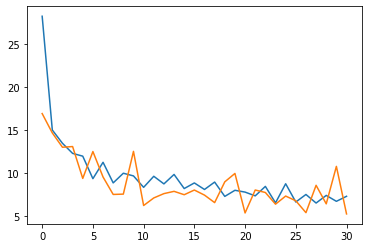

In [102]:
import matplotlib.pyplot as plt
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])

In [103]:
res = model.evaluate(X_test, y_test, verbose=0)

print(f'MAPE on the test set : {res[1]:.0f} %')

MAPE on the test set : 247 %


In [48]:
x_columns = (list(set(columns)))
x_columns.remove('bovespa')
X_train = df_train[x_columns]
y_train = df_train['bovespa']
X_test = df_test[x_columns]
y_test = df_test['bovespa']